## IMPORTS

In [38]:
from math import sin, cos, atan2, sqrt, pi, acos, hypot

# Supondo que o código do algoritmo de Dubins fornecido esteja disponível no mesmo script ou importado corretamente
from utils.plot import plot_arrow

from utils.angle import angle_mod, rot_mat_2d
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## DTSP

In [39]:
"""

Dubins path planner sample code

author Atsushi Sakai(@Atsushi_twi)

"""

def plan_dubins_path(s_x, s_y, s_yaw, g_x, g_y, g_yaw, curvature,
                     step_size=0.1, selected_types=None):
    """
    Plan dubins path

    Parameters
    ----------
    s_x : float
        x position of the start point [m]
    s_y : float
        y position of the start point [m]
    s_yaw : float
        yaw angle of the start point [rad]
    g_x : float
        x position of the goal point [m]
    g_y : float
        y position of the end point [m]
    g_yaw : float
        yaw angle of the end point [rad]
    curvature : float
        curvature for curve [1/m]
    step_size : float (optional)
        step size between two path points [m]. Default is 0.1
    selected_types : a list of string or None
        selected path planning types. If None, all types are used for
        path planning, and minimum path length result is returned.
        You can select used path plannings types by a string list.
        e.g.: ["RSL", "RSR"]

    Returns
    -------
    x_list: array
        x positions of the path
    y_list: array
        y positions of the path
    yaw_list: array
        yaw angles of the path
    modes: array
        mode list of the path
    lengths: array
        arrow_length list of the path segments.

    Examples
    --------
    You can generate a dubins path.

    >>> start_x = 1.0  # [m]
    >>> start_y = 1.0  # [m]
    >>> start_yaw = np.deg2rad(45.0)  # [rad]
    >>> end_x = -3.0  # [m]
    >>> end_y = -3.0  # [m]
    >>> end_yaw = np.deg2rad(-45.0)  # [rad]
    >>> curvature = 1.0
    >>> path_x, path_y, path_yaw, mode, _ = plan_dubins_path(
                start_x, start_y, start_yaw, end_x, end_y, end_yaw, curvature)
    >>> plt.plot(path_x, path_y, label="final course " + "".join(mode))
    >>> plot_arrow(start_x, start_y, start_yaw)
    >>> plot_arrow(end_x, end_y, end_yaw)
    >>> plt.legend()
    >>> plt.grid(True)
    >>> plt.axis("equal")
    >>> plt.show()

    .. image:: dubins_path.jpg
    """
    if selected_types is None:
        planning_funcs = _PATH_TYPE_MAP.values()
    else:
        planning_funcs = [_PATH_TYPE_MAP[ptype] for ptype in selected_types]

    # calculate local goal x, y, yaw
    l_rot = rot_mat_2d(s_yaw)
    le_xy = np.stack([g_x - s_x, g_y - s_y]).T @ l_rot
    local_goal_x = le_xy[0]
    local_goal_y = le_xy[1]
    local_goal_yaw = g_yaw - s_yaw

    lp_x, lp_y, lp_yaw, modes, lengths = _dubins_path_planning_from_origin(
        local_goal_x, local_goal_y, local_goal_yaw, curvature, step_size,
        planning_funcs)

    # Convert a local coordinate path to the global coordinate
    rot = rot_mat_2d(-s_yaw)
    converted_xy = np.stack([lp_x, lp_y]).T @ rot
    x_list = converted_xy[:, 0] + s_x
    y_list = converted_xy[:, 1] + s_y
    yaw_list = angle_mod(np.array(lp_yaw) + s_yaw)

    return x_list, y_list, yaw_list, modes, lengths


def _mod2pi(theta):
    return angle_mod(theta, zero_2_2pi=True)


def _calc_trig_funcs(alpha, beta):
    sin_a = sin(alpha)
    sin_b = sin(beta)
    cos_a = cos(alpha)
    cos_b = cos(beta)
    cos_ab = cos(alpha - beta)
    return sin_a, sin_b, cos_a, cos_b, cos_ab


def _LSL(alpha, beta, d):
    sin_a, sin_b, cos_a, cos_b, cos_ab = _calc_trig_funcs(alpha, beta)
    mode = ["L", "S", "L"]
    p_squared = 2 + d ** 2 - (2 * cos_ab) + (2 * d * (sin_a - sin_b))
    if p_squared < 0:  # invalid configuration
        return None, None, None, mode
    tmp = atan2((cos_b - cos_a), d + sin_a - sin_b)
    d1 = _mod2pi(-alpha + tmp)
    d2 = sqrt(p_squared)
    d3 = _mod2pi(beta - tmp)
    return d1, d2, d3, mode


def _RSR(alpha, beta, d):
    sin_a, sin_b, cos_a, cos_b, cos_ab = _calc_trig_funcs(alpha, beta)
    mode = ["R", "S", "R"]
    p_squared = 2 + d ** 2 - (2 * cos_ab) + (2 * d * (sin_b - sin_a))
    if p_squared < 0:
        return None, None, None, mode
    tmp = atan2((cos_a - cos_b), d - sin_a + sin_b)
    d1 = _mod2pi(alpha - tmp)
    d2 = sqrt(p_squared)
    d3 = _mod2pi(-beta + tmp)
    return d1, d2, d3, mode


def _LSR(alpha, beta, d):
    sin_a, sin_b, cos_a, cos_b, cos_ab = _calc_trig_funcs(alpha, beta)
    p_squared = -2 + d ** 2 + (2 * cos_ab) + (2 * d * (sin_a + sin_b))
    mode = ["L", "S", "R"]
    if p_squared < 0:
        return None, None, None, mode
    d1 = sqrt(p_squared)
    tmp = atan2((-cos_a - cos_b), (d + sin_a + sin_b)) - atan2(-2.0, d1)
    d2 = _mod2pi(-alpha + tmp)
    d3 = _mod2pi(-_mod2pi(beta) + tmp)
    return d2, d1, d3, mode


def _RSL(alpha, beta, d):
    sin_a, sin_b, cos_a, cos_b, cos_ab = _calc_trig_funcs(alpha, beta)
    p_squared = d ** 2 - 2 + (2 * cos_ab) - (2 * d * (sin_a + sin_b))
    mode = ["R", "S", "L"]
    if p_squared < 0:
        return None, None, None, mode
    d1 = sqrt(p_squared)
    tmp = atan2((cos_a + cos_b), (d - sin_a - sin_b)) - atan2(2.0, d1)
    d2 = _mod2pi(alpha - tmp)
    d3 = _mod2pi(beta - tmp)
    return d2, d1, d3, mode


def _RLR(alpha, beta, d):
    sin_a, sin_b, cos_a, cos_b, cos_ab = _calc_trig_funcs(alpha, beta)
    mode = ["R", "L", "R"]
    tmp = (6.0 - d ** 2 + 2.0 * cos_ab + 2.0 * d * (sin_a - sin_b)) / 8.0
    if abs(tmp) > 1.0:
        return None, None, None, mode
    d2 = _mod2pi(2 * pi - acos(tmp))
    d1 = _mod2pi(alpha - atan2(cos_a - cos_b, d - sin_a + sin_b) + d2 / 2.0)
    d3 = _mod2pi(alpha - beta - d1 + d2)
    return d1, d2, d3, mode


def _LRL(alpha, beta, d):
    sin_a, sin_b, cos_a, cos_b, cos_ab = _calc_trig_funcs(alpha, beta)
    mode = ["L", "R", "L"]
    tmp = (6.0 - d ** 2 + 2.0 * cos_ab + 2.0 * d * (- sin_a + sin_b)) / 8.0
    if abs(tmp) > 1.0:
        return None, None, None, mode
    d2 = _mod2pi(2 * pi - acos(tmp))
    d1 = _mod2pi(-alpha - atan2(cos_a - cos_b, d + sin_a - sin_b) + d2 / 2.0)
    d3 = _mod2pi(_mod2pi(beta) - alpha - d1 + _mod2pi(d2))
    return d1, d2, d3, mode


_PATH_TYPE_MAP = {"LSL": _LSL, "RSR": _RSR, "LSR": _LSR, "RSL": _RSL,
                  "RLR": _RLR, "LRL": _LRL, }


def _dubins_path_planning_from_origin(end_x, end_y, end_yaw, curvature,
                                      step_size, planning_funcs):
    dx = end_x
    dy = end_y
    d = hypot(dx, dy) * curvature

    theta = _mod2pi(atan2(dy, dx))
    alpha = _mod2pi(-theta)
    beta = _mod2pi(end_yaw - theta)

    best_cost = float("inf")
    b_d1, b_d2, b_d3, b_mode = None, None, None, None

    for planner in planning_funcs:
        d1, d2, d3, mode = planner(alpha, beta, d)
        if d1 is None:
            continue

        cost = (abs(d1) + abs(d2) + abs(d3))
        if best_cost > cost:  # Select minimum length one.
            b_d1, b_d2, b_d3, b_mode, best_cost = d1, d2, d3, mode, cost

    lengths = [b_d1, b_d2, b_d3]
    x_list, y_list, yaw_list = _generate_local_course(lengths, b_mode,
                                                      curvature, step_size)

    lengths = [length / curvature for length in lengths]

    return x_list, y_list, yaw_list, b_mode, lengths


def _interpolate(length, mode, max_curvature, origin_x, origin_y,
                 origin_yaw, path_x, path_y, path_yaw):
    if mode == "S":
        path_x.append(origin_x + length / max_curvature * cos(origin_yaw))
        path_y.append(origin_y + length / max_curvature * sin(origin_yaw))
        path_yaw.append(origin_yaw)
    else:  # curve
        ldx = sin(length) / max_curvature
        ldy = 0.0
        if mode == "L":  # left turn
            ldy = (1.0 - cos(length)) / max_curvature
        elif mode == "R":  # right turn
            ldy = (1.0 - cos(length)) / -max_curvature
        gdx = cos(-origin_yaw) * ldx + sin(-origin_yaw) * ldy
        gdy = -sin(-origin_yaw) * ldx + cos(-origin_yaw) * ldy
        path_x.append(origin_x + gdx)
        path_y.append(origin_y + gdy)

        if mode == "L":  # left turn
            path_yaw.append(origin_yaw + length)
        elif mode == "R":  # right turn
            path_yaw.append(origin_yaw - length)

    return path_x, path_y, path_yaw


def _generate_local_course(lengths, modes, max_curvature, step_size):
    p_x, p_y, p_yaw = [0.0], [0.0], [0.0]

    for (mode, length) in zip(modes, lengths):
        if length == 0.0:
            continue

        # set origin state
        origin_x, origin_y, origin_yaw = p_x[-1], p_y[-1], p_yaw[-1]

        current_length = step_size
        while abs(current_length + step_size) <= abs(length):
            p_x, p_y, p_yaw = _interpolate(current_length, mode, max_curvature,
                                           origin_x, origin_y, origin_yaw,
                                           p_x, p_y, p_yaw)
            current_length += step_size

        p_x, p_y, p_yaw = _interpolate(length, mode, max_curvature, origin_x,
                                       origin_y, origin_yaw, p_x, p_y, p_yaw)

    return p_x, p_y, p_yaw

## ALGORITMO GENÉTICO

In [40]:
# Função para calcular o caminho de Dubins entre dois pontos
def dubins_path_length(point1, point2, turning_radius):
    q0 = (point1[0], point1[1], point1[2])  # ponto inicial (x, y, ângulo)
    q1 = (point2[0], point2[1], point2[2])  # ponto final (x, y, ângulo)
    x_list, y_list, yaw_list, modes, lengths = plan_dubins_path(point1[0], point1[1], point1[2], point2[0], point2[1], point2[2], turning_radius)
    return sum(lengths)

# Define o problema DTSP com coordenadas e ângulos
class DTSP:
    def __init__(self, points, turning_radius):
        self.points = points
        self.turning_radius = turning_radius
        self.qtd_points = len(points)
        self.distance_matrix = self.create_distance_matrix()

    def create_distance_matrix(self):
        distance_matrix = np.zeros((self.qtd_points, self.qtd_points))
        for i in range(self.qtd_points):
            for j in range(self.qtd_points):
                if i != j:
                    distance_matrix[i][j] = dubins_path_length(self.points[i], self.points[j], self.turning_radius)
        return distance_matrix

    def get_distance(self, route):
        distance = 0
        for i in range(len(route)):
            distance += self.distance_matrix[route[i-1]][route[i]]
        return distance

In [41]:
# Funções auxiliares para o algoritmo genético
def create_route(dtsp):
    route = list(range(dtsp.qtd_points))
    random.shuffle(route)
    return route

In [42]:

def initial_population(dtsp, population_size):
    return [create_route(dtsp) for _ in range(population_size)]

def rank_routes(dtsp, population):
    fitness_results = {}
    for i, route in enumerate(population):
        fitness_results[i] = 1 / float(dtsp.get_distance(route))
    return sorted(fitness_results.items(), key=lambda x: x[1], reverse=True)

In [43]:
def selection(pop_ranked, elite_size):
    selection_results = []
    df = pd.DataFrame(np.array(pop_ranked), columns=["Index", "Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100 * df.cum_sum / df.Fitness.sum()

    for i in range(elite_size):
        selection_results.append(pop_ranked[i][0])
    for i in range(len(pop_ranked) - elite_size):
        pick = 100 * random.random()
        for i in range(len(pop_ranked)):
            if pick <= df.iat[i, 3]:
                selection_results.append(pop_ranked[i][0])
                break
    return selection_results

def mating_pool(population, selection_results):
    matingpool = []
    for i in range(len(selection_results)):
        index = selection_results[i]
        matingpool.append(population[index])
    return matingpool

def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []

    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))

    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])

    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

def breed_population(matingpool, elite_size):
    children = []
    length = len(matingpool) - elite_size
    pool = random.sample(matingpool, len(matingpool))

    for i in range(elite_size):
        children.append(matingpool[i])

    for i in range(length):
        child = breed(pool[i], pool[len(matingpool) - i - 1])
        children.append(child)
    return children

def mutate(individual, mutation_rate):
    for swapped in range(len(individual)):
        if(random.random() < mutation_rate):
            swap_with = int(random.random() * len(individual))

            city1 = individual[swapped]
            city2 = individual[swap_with]

            individual[swapped] = city2
            individual[swap_with] = city1
    return individual

def mutate_population(population, mutation_rate):
    mutated_pop = []

    for ind in range(len(population)):
        mutated_ind = mutate(population[ind], mutation_rate)
        mutated_pop.append(mutated_ind)
    return mutated_pop

def next_generation(current_gen, elite_size, mutation_rate, dtsp):
    pop_ranked = rank_routes(dtsp, current_gen)
    selection_results = selection(pop_ranked, elite_size)
    matingpool = mating_pool(current_gen, selection_results)
    children = breed_population(matingpool, elite_size)
    next_generation = mutate_population(children, mutation_rate)
    return next_generation

def genetic_algorithm(dtsp, population_size, elite_size, mutation_rate, generations):
    pop = initial_population(dtsp, population_size)
    print(f"Initial distance: {1 / rank_routes(dtsp, pop)[0][1]}")

    for i in range(generations):
        pop = next_generation(pop, elite_size, mutation_rate, dtsp)

    print(f"Final distance: {1 / rank_routes(dtsp, pop)[0][1]}")
    best_route_index = rank_routes(dtsp, pop)[0][0]
    best_route = pop[best_route_index]
    return best_route

## PLOTS

In [44]:
# Função para plotar a melhor rota
def plot_route(dtsp, route):
    route_coords = [dtsp.points[i][:2] for i in route]
    route_coords.append(route_coords[0])  # Para fechar o ciclo
    route_coords = np.array(route_coords)

    plt.figure(figsize=(10, 6))
    plt.plot(route_coords[:, 0], route_coords[:, 1], 'o-', markersize=10)
    plt.title('Melhor Rota Encontrada')
    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.show()

In [45]:
def plot_best_route_dubins(route, dtsp, turning_radius):
    plt.figure(figsize=(10, 6))
    for i in range(len(route)):
        start_point = dtsp.points[route[i-1]]
        end_point = dtsp.points[route[i]]
        path_x, path_y, path_angle, modes, lengths = plan_dubins_path(start_point[0], 
                                start_point[1],
                                start_point[2],
                                 end_point[0],
                                 end_point[1],
                                 end_point[2], 
                                 turning_radius)
        plt.plot(path_x, path_y, 'o-', markersize=2)
    
    plt.title('Melhor Rota Encontrada')
    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.show()

# TESTES

In [46]:
# Exemplo de uso do algoritmo genético com coordenadas e ângulos
# points = [
#     (0, 0, 0),     # (x, y, ângulo)
#     (1, 3, np.pi/4),
#     (4, 3, np.pi/2),
#     (6, 1, np.pi),
#     (3, 5, 3*np.pi/2),
#     (5, 5, 0)
# ]

# points = [
#     (0, 0, 0),     # (x, y, ângulo)
#     (0.5, 0.8, np.pi/4),
#     (1, 2, np.pi/2),
#     (2, 1, np.pi),
#     (-1, -2, 3*np.pi/2),
#     (1.5, 1.5, 0)
# ]


points = [
    (0, 0, 0),     # (x, y, ângulo)
    (-1.5, -1.8, np.pi/4),
    (-1.5, 2.5, np.pi/2),
    (1.5, 2.5, np.pi),
    (1.5, -1.8, 3*np.pi/2)
]

Initial distance: 23.97639510437498
Final distance: 23.97639510437498
Melhor rota: [4, 1, 2, 3, 0]


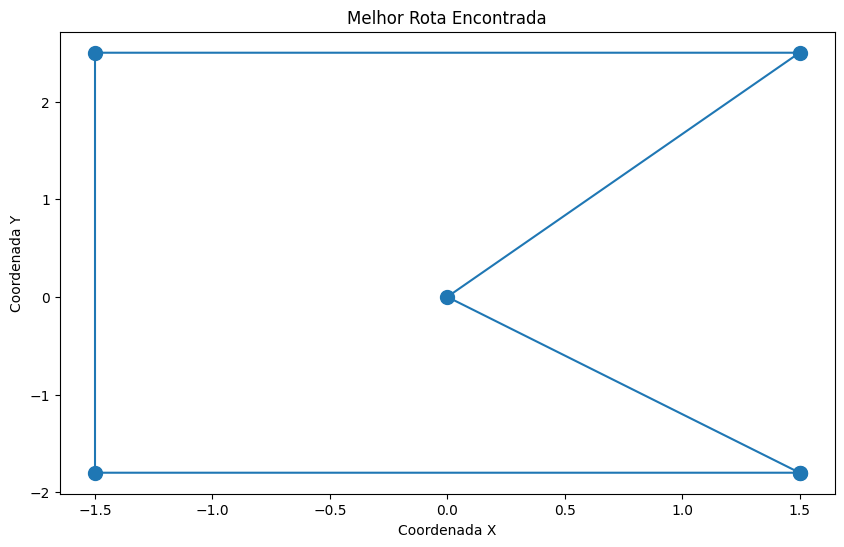

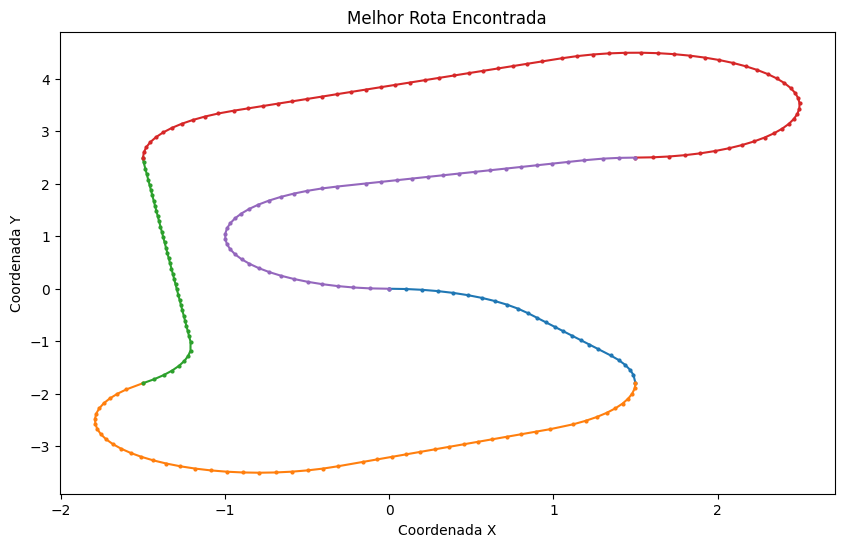

In [47]:
turning_radius = 1.0  # Raio de curvatura mínimo

dtsp = DTSP(points, turning_radius)
best_route = genetic_algorithm(dtsp, population_size=100, elite_size=20, mutation_rate=0.01, generations=500)
print(f"Melhor rota: {best_route}")
plot_route(dtsp, best_route)


plot_best_route_dubins(best_route, dtsp, turning_radius)

# COPPELIA

In [48]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

In [49]:
# ---------------------------------------------- Init ----------------------------------------
try:
    client = RemoteAPIClient()
    sim = client.require('sim')
except:
    print('Error connection')

In [50]:
#Informações do Robô
L = 0.230
R = 0.035
ROBOT = "kobuki"
maxv = 1.0
maxw = np.deg2rad(45)

#Handles
objectHandle_RP = sim.getObject("/" + ROBOT)
robotHandle = sim.getObject("/" + ROBOT)  
robotLeftMotorHandle = sim.getObject("/" +'kobuki_leftMotor')
robotRightMotorHandle = sim.getObject("/" +'kobuki_rightMotor')

robot_path = []


In [51]:
def normalizeAngle(angle):
    return np.mod(angle + np.pi, 2 * np.pi) - np.pi

### Navegação

In [52]:
def navigation(qgoal):
    rho = np.inf
    while rho > 0.05:
        #Configuração do robo
        robotPos = sim.getObjectPosition(robotHandle, sim.handle_world)   
        robotOri = sim.getObjectOrientation(objectHandle_RP, 
                                                sim.handle_world)
        robotConfig = np.array([robotPos[0], robotPos[1], robotOri[2]])

        robotPos = robotPos[0:2]
        robot_path.append(robotPos)

        dx, dy, dth = qgoal - robotConfig

        rho = np.sqrt(dx**2 + dy**2)
        alpha = normalizeAngle(-robotConfig[2] + np.arctan2(dy, dx))
        beta = normalizeAngle(qgoal[2] - np.arctan2(dy, dx))

        kr = 4 / 20
        ka = 8 / 20
        kb = -1.5 / 20

        if abs(alpha) > np.pi/2:
            kr = -kr       
            alpha = normalizeAngle(alpha - np.pi)
            beta = normalizeAngle(beta - np.pi)

        v = kr * rho
        w = ka * alpha + kb * beta

        v = max(min(v, maxv), -maxv)
        w = max(min(w, maxw), -maxw)

        wr = ((2.0 * v) + (w * L)) / (2.0 * R)
        wl = ((2.0 * v) - (w * L)) / (2.0 * R)

        sim.setJointTargetVelocity(robotRightMotorHandle, wr)
        sim.setJointTargetVelocity(robotLeftMotorHandle, wl)

In [53]:
qstart = list(dtsp.points[best_route[0]])
print(qstart)

[1.5, -1.8, 4.71238898038469]


In [54]:

sim.startSimulation()

sim.setObjectPosition(robotHandle, qstart)

def main(route):
    for i in range(len(route)):
        dubins_path = []
        start_point = dtsp.points[route[i-1]]
        end_point = dtsp.points[route[i]]
        path_x, path_y, path_angle, modes, lengths = plan_dubins_path(start_point[0], 
                                start_point[1],
                                start_point[2],
                                end_point[0],
                                end_point[1],
                                end_point[2], 
                                turning_radius)
        for x, y, angle in zip(path_x, path_y, path_angle):
            dubins_path.append(np.array([x,y,angle]))

        for qgoal in dubins_path:
            navigation(qgoal)
    sim.setJointTargetVelocity(robotRightMotorHandle, 0)
    sim.setJointTargetVelocity(robotLeftMotorHandle, 0)
    sim.stopSimulation()

main(best_route)

## PLOT CAMINHO DO ROBÔ

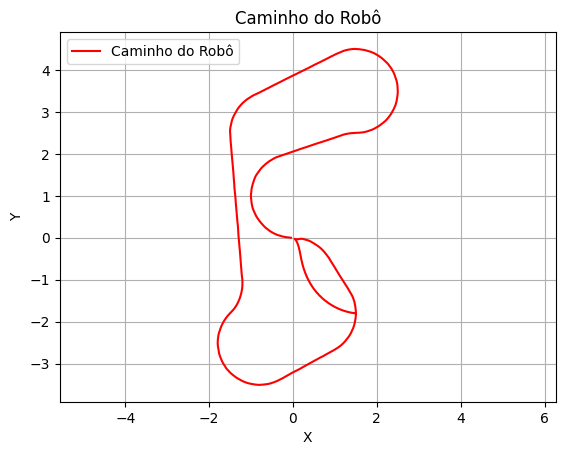

In [55]:
robot_path = np.array(robot_path)
plt.plot(robot_path[:, 0], robot_path[:, 1], '-r', label='Caminho do Robô')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Caminho do Robô')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.savefig("robot_path.png")
plt.show()